In [1]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_2_open_solver_1.json")

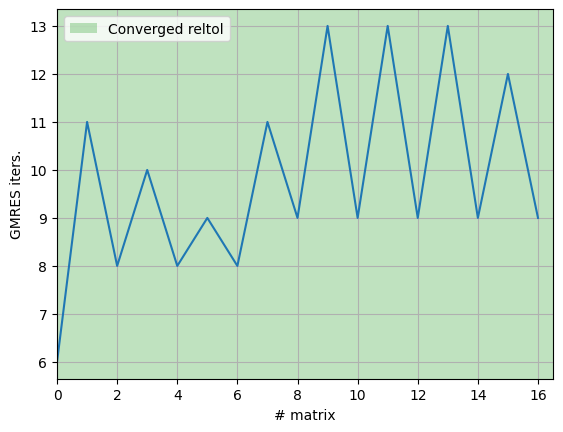

In [2]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [3]:
mat_idx = 14
get_gmres_iterations(data)[mat_idx]

9

In [4]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [5]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Solve  took: 0.79


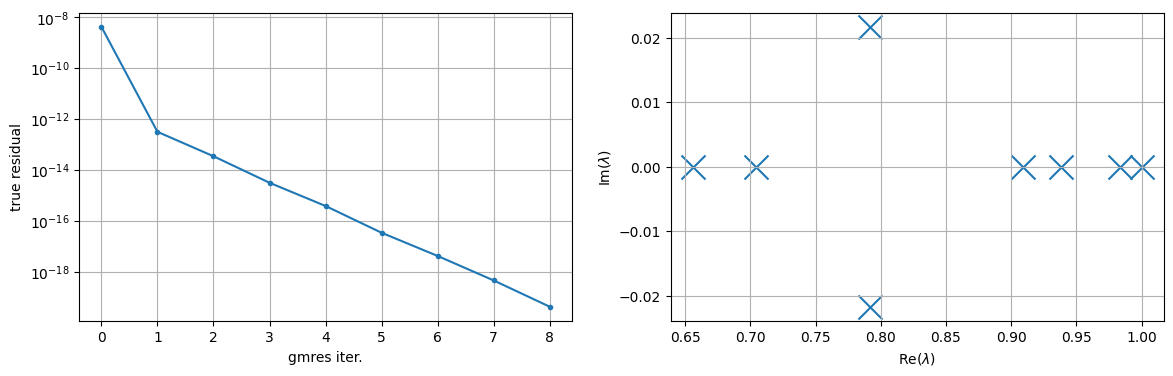

In [6]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

In [7]:
def correct_eq_groups(model):
    """We reindex eq_dofs and model._equation_groups to put together normal and tangential components of the contact equation for each dof."""
    eq_dofs_corrected = [x.copy() for x in model.eq_dofs]
    eq_groups_corrected = [x.copy() for x in model._equation_groups]

    end_normal = len(model._equation_groups[4]) // 2
    normal_subgroups = model._equation_groups[4][:end_normal]

    eq_dofs_corrected = []
    for i, x in enumerate(model.eq_dofs):
        if i not in model._equation_groups[4]:
            eq_dofs_corrected.append(x)
        else:
            if i in normal_subgroups:
                eq_dofs_corrected.append(None)

    i = model.eq_dofs[normal_subgroups[0]][0]
    for normal in normal_subgroups:
        res = i + np.arange(model.eq_dofs[normal].size * model.nd)
        i = res[-1] + 1
        eq_dofs_corrected[normal] = np.array(res)

    eq_groups_corrected[4] = normal_subgroups
    eq_groups_corrected[5] = (
        np.array(model._equation_groups[5]) - end_normal
    ).tolist()

    return eq_dofs_corrected, eq_groups_corrected

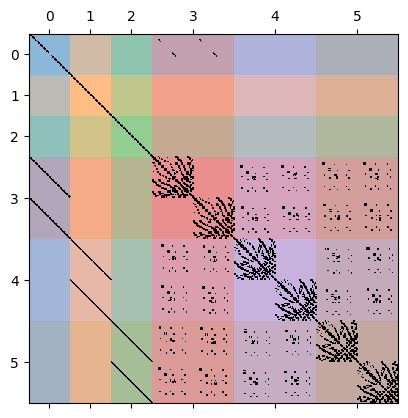

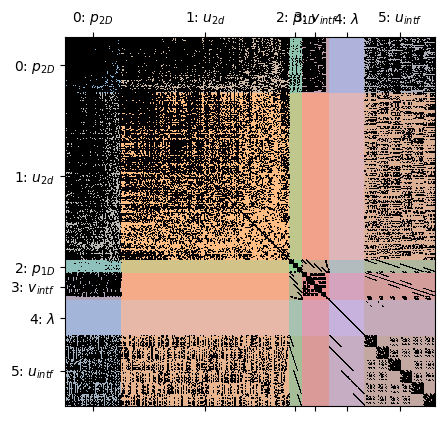

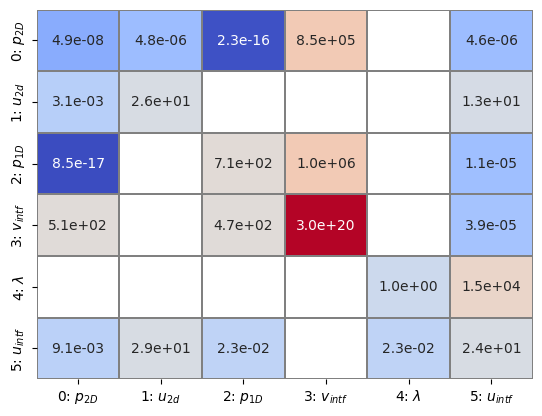

In [8]:
from block_matrix import BlockMatrixStorage

corrected_eq_dofs, corrected_eq_groups = correct_eq_groups(model)

J = BlockMatrixStorage(
    mat=mat,
    row_idx=corrected_eq_dofs,
    col_idx=model.var_dofs,
    groups_row=corrected_eq_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)

J[[4, 5]].color_spy(False)

J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

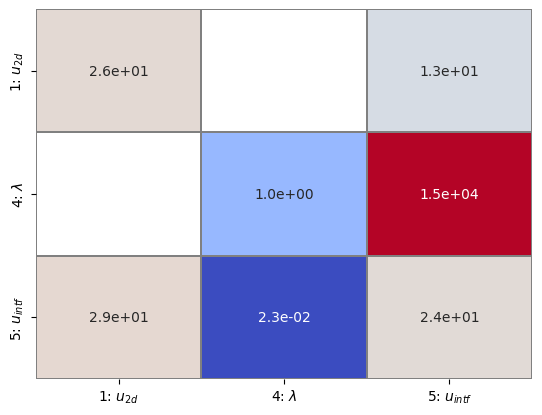

In [9]:
J_mech = J[[1,4,5]]
J_mech.plot_max()


Solve  took: 0.17


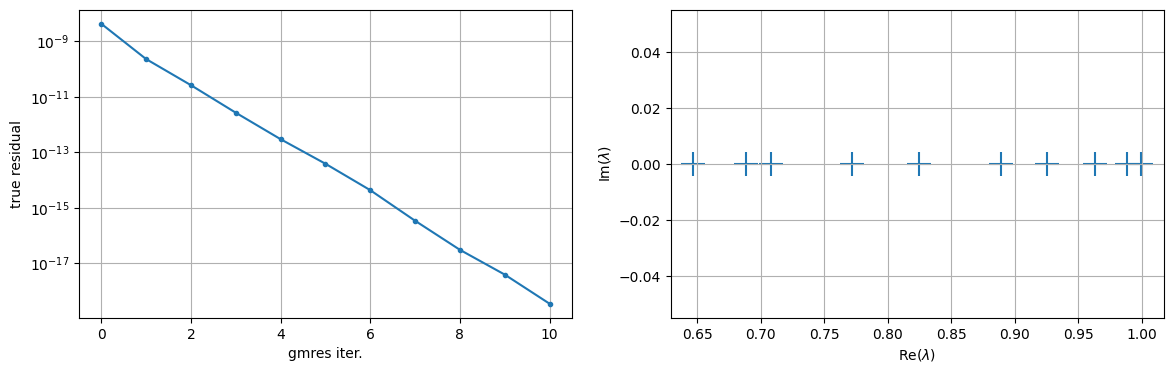

In [10]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization

schema_1 = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema_45_1 = SolveSchema(
    groups=[4, 5],
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

/home/porepy/simulations/plot_utils.py:101: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


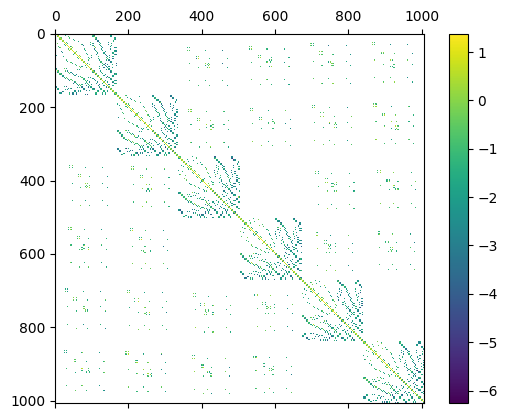

In [11]:
# J_mech[[5]].color_spy()
J_mech[[5]].matshow()

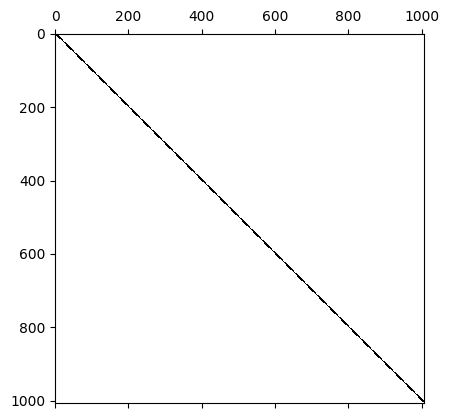

In [33]:
J55_lumped = lump_nd(J[[5]].mat, nd=model.nd)
spy(inv(J55_lumped))

# Luming works quite well

nd = 3 not implemented, using direct inverse
nd = 3 not implemented, using direct inverse
Solve  took: 0.0


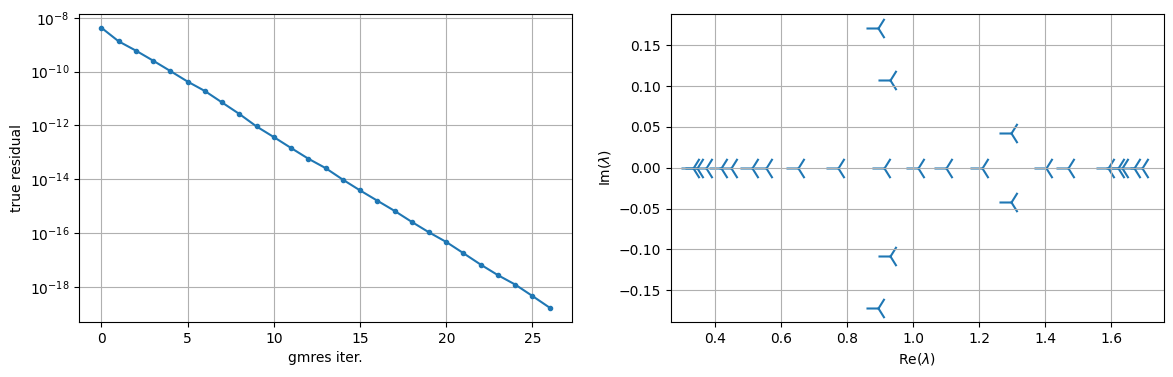

In [37]:
schema_5_4 = SolveSchema(
    groups=[5],
    solve='use_invertor',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(abs(bmat.mat)) / 6,
    # invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),


    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: inv_block_diag_2x2(bmat.mat),
        solve=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    )
)

mat_permuted, prec = make_solver(schema=schema_5_4, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Note: It's not good enough to just take a diagonal approximation of J55

nd = 3 not implemented, using direct inverse
nd = 3 not implemented, using direct inverse
Solve  took: 0.43


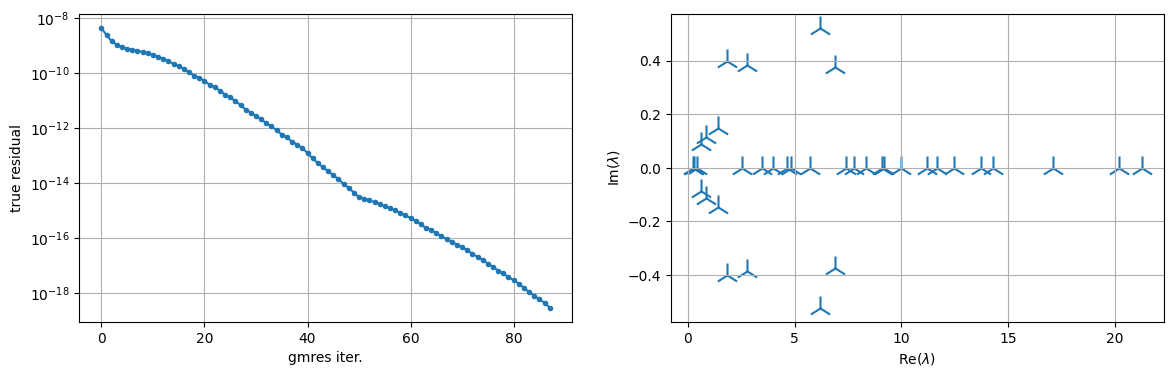

In [14]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    # solve='direct',
    solve='use_invertor',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),

    complement=SolveSchema(
        groups=[4],
        solve='use_invertor',
        # invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),

        complement=schema_1,
    ),
    # complement=schema_1
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

(ABOVE SHOULD FAIL without lumping)

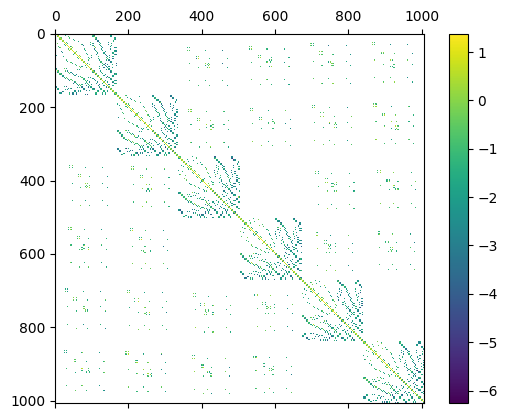

In [15]:
J[[5]].matshow()

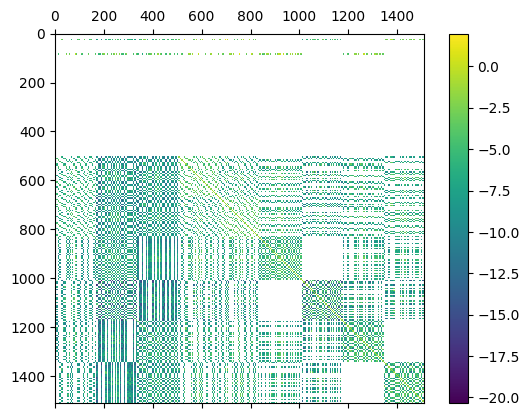

In [16]:
plot_mat(inv(J[[4,5]].mat))

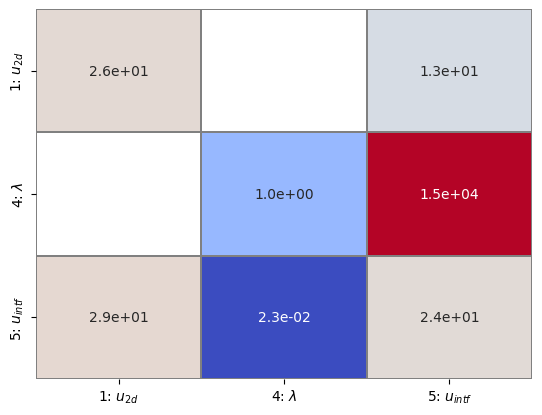

In [17]:
J_mech.plot_max()

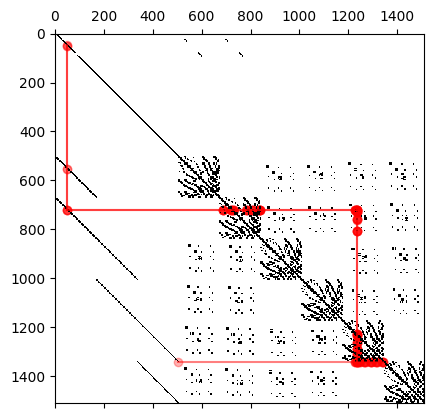

In [18]:
# %matplotlib tk


tmp = J_mech[[4, 5]].mat
spy(tmp, show=False)

row_start = 50
col_start = 50
recursion = 4

def connect_vertices(mat, mat_t, row_start, col_start, recursion=1, transposed=False):
    if recursion == 0:
        return
    
    mat_t = mat_t.tocsr()
    mat = mat.tocsr()    
    cols = mat[row_start].indices
    if not transposed:
        plt.plot([min(cols), max(cols)], [row_start, row_start], alpha=0.5, color='red')
        plt.scatter(cols, [row_start] * len(cols), color='red', alpha=0.3)
    else:
        plt.plot([row_start, row_start], [min(cols), max(cols)], alpha=0.5, color='red')
        plt.scatter([row_start] * len(cols), cols, color='red', alpha=0.3)

    col = cols[np.argmax(abs(cols - col_start))]
    connect_vertices(mat_t, mat, row_start=col, col_start=row_start, recursion=recursion-1, transposed=not transposed)

connect_vertices(tmp, tmp.T, row_start=row_start, col_start=col_start, recursion=recursion)
connect_vertices(tmp.T, tmp, row_start=col_start, col_start=row_start, recursion=recursion, transposed=True)

3d problem with 1 fracture?

Scalable?

Lumping

what I proposed

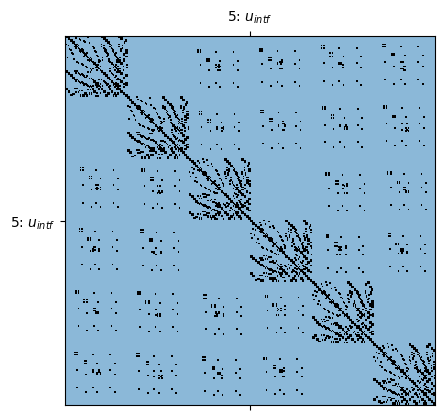

In [19]:
J[[5]].color_spy()

In [20]:
from preconditioner_mech import build_mechanics_stabilization

mech_stab = build_mechanics_stabilization(model, J, build_schur=False)

print(cond(J[[4, 5]].mat @ mech_stab)) # First is small
print(cond(mech_stab @ J[[4, 5]].mat)) # This is large

8.286445966070007
56168.557823092546


Solve  took: 0.65
PETSc Converged Reason: -5


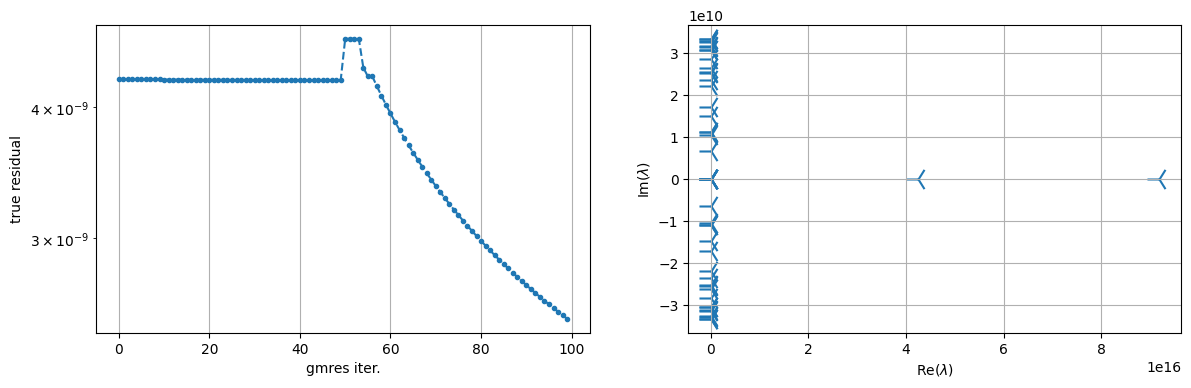

In [21]:
# Block diag inv

schema_45_1 = SolveSchema(
    groups=[5],
    solve=lambda x: x.block_diag_inv(),
    invertor=lambda x: x.block_diag_inv(),
    complement=SolveSchema(
        groups=[4],
        solve=lambda x: x.block_diag_inv(),
        invertor=lambda x: x.block_diag_inv(),
        complement=schema_1,
    )
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs), logx_eigs=False)

Solve  took: 0.78
PETSc Converged Reason: -5


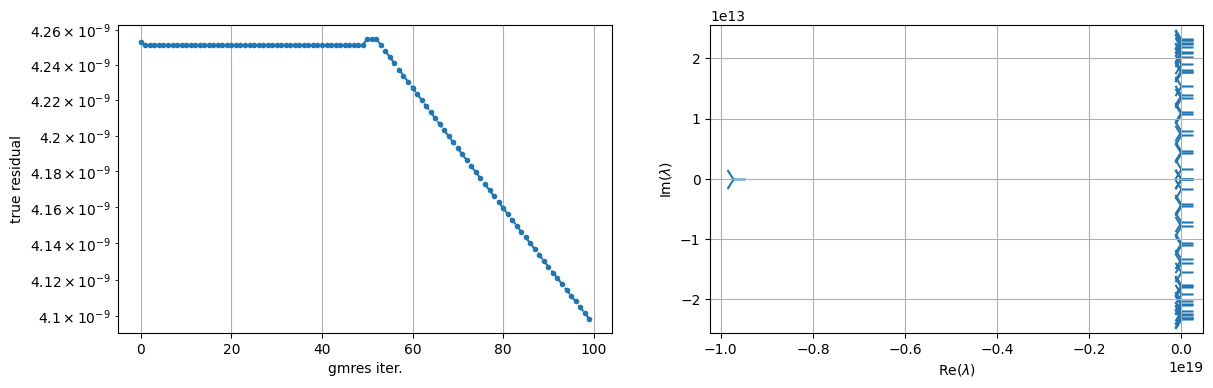

In [22]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    invertor=lambda: build_mechanics_stabilization(model, J),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

nd = 3 not implemented, using direct inverse
nd = 3 not implemented, using direct inverse
Solve  took: 0.44


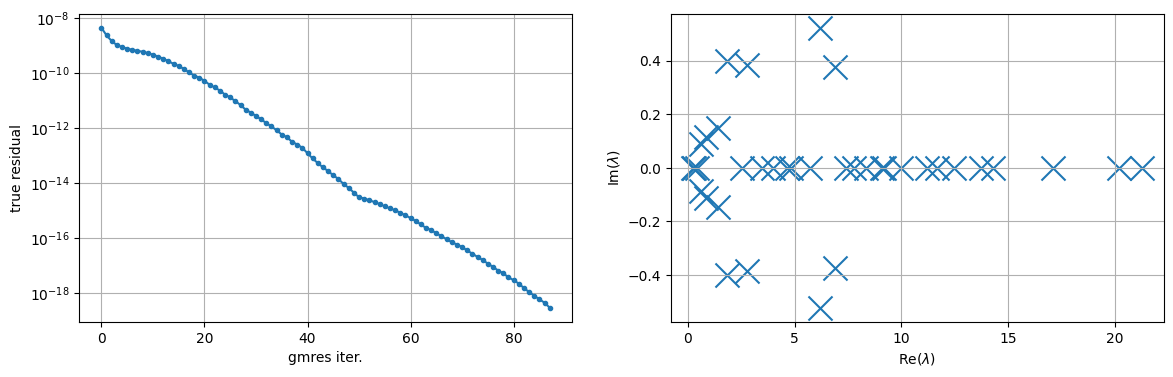

In [23]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    solve='use_invertor',
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),
    complement=SolveSchema(
        groups=[4],
        solve='use_invertor',
        invertor=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
        complement=schema_1,
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

(ABOVE SHOULD FAIL)

# How to solve blocks 4 and 5 not by a direct solver?

Solve  took: 0.0


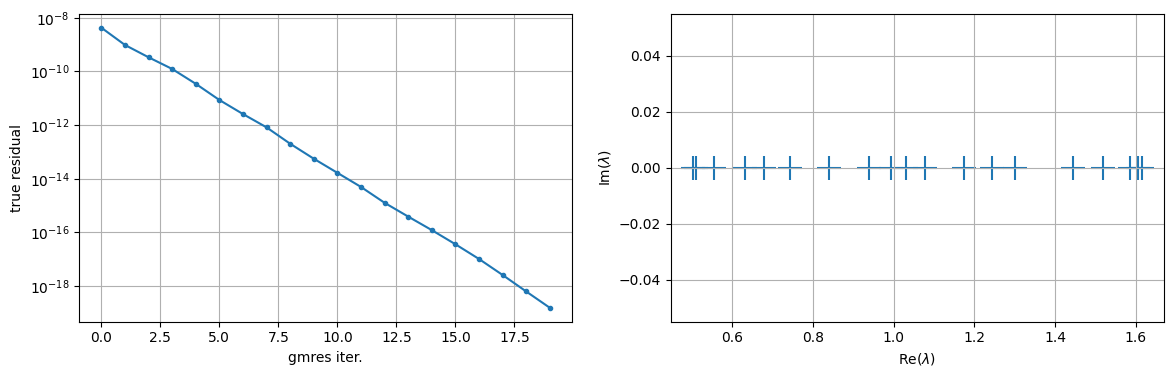

In [24]:
schema_45 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(model=model, bmat=bmat, build_schur=False),
)

mat_permuted, prec = make_solver(schema=schema_45, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.28
PETSc Converged Reason: -5


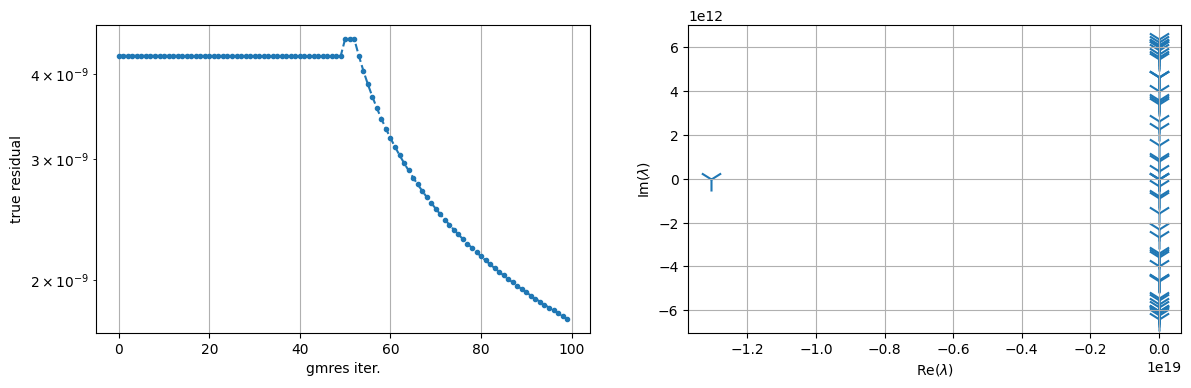

In [25]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(model=model, bmat=bmat, build_schur=False),
    invertor=lambda: build_mechanics_stabilization(model=model, bmat=J),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# Full matrix

Solve  took: 0.95
PETSc Converged Reason: -5


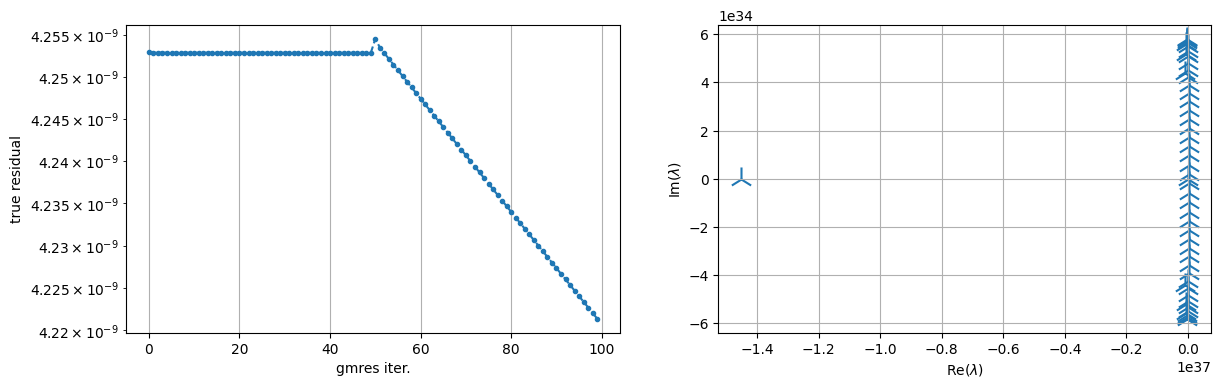

In [26]:
from pp_utils import get_fixed_stress_stabilization_nd


def fill_empty_blocks(mat):
    empty_0 = scipy.sparse.csr_matrix(J[[0]].shape)
    empty_2 = scipy.sparse.csr_matrix(J[[2]].shape)
    return scipy.sparse.block_diag(
        [
            mat,
            empty_0,
            # empty_2,
        ]
    ).tocsr()


schema_02 = SolveSchema(
    groups=[
        0,
        # 2,
    ],
    solve=lambda bmat: PetscAMGFlow(bmat.mat),
    # solve='direct'
)

solve_1_02 = SolveSchema(
    groups=[1],
    complement=schema_02,
    invertor=lambda: get_fixed_stress_stabilization(model),
    invertor_type="physical",
    # invertor='direct',
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    # solve='direct'
)

schema_45_1_02 = SolveSchema(
    groups=[4, 5],
    complement=solve_1_02,
    invertor=lambda: fill_empty_blocks(build_mechanics_stabilization(model=model, bmat=J)),
    invertor_type="physical",
    # solve=lambda bmat: build_mechanics_stabilization(build_schur=False),
    # invertor=lambda: build_mechanics_stabilization(),
)

schema_3_45_1_02 = SolveSchema(
    groups=[3],
    complement=schema_45_1_02,
    # solve=lambda bmat: PetscILU(mat=bmat.mat, factor_levels=1),
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
)

mat_permuted, prec = make_solver(schema=schema_45_1_02, mat_orig=J[[0, 1, 3, 4, 5]])
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

If we remove J22, it solves (fpm_0). So the default FS for the ambient dimension is "almost" sufficient

# Lumping

Solve  took: 0.87


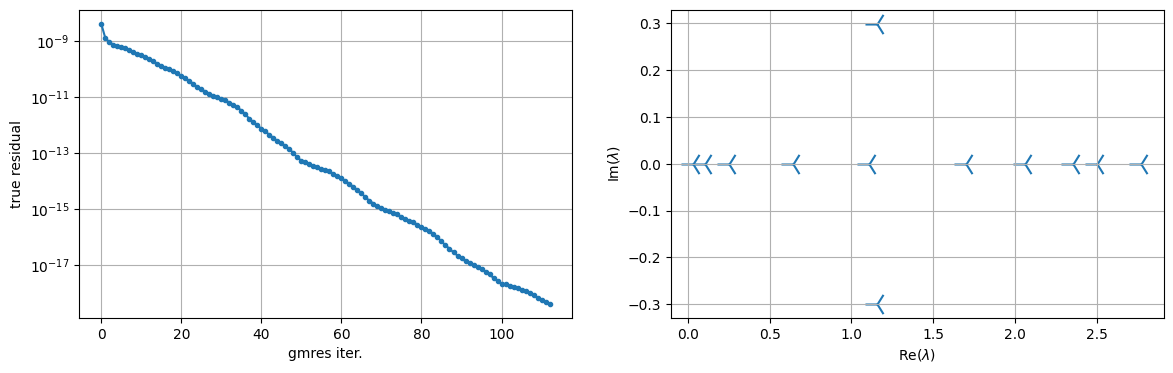

In [27]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    # solve='use_invertor',
    # invertor=lambda x: scipy.sparse.eye(x.shape[0]),

    invertor=lambda: build_mechanics_stabilization(model, J, lump=True),
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

nd = 3 not implemented, using direct inverse
Solve  took: 0.0


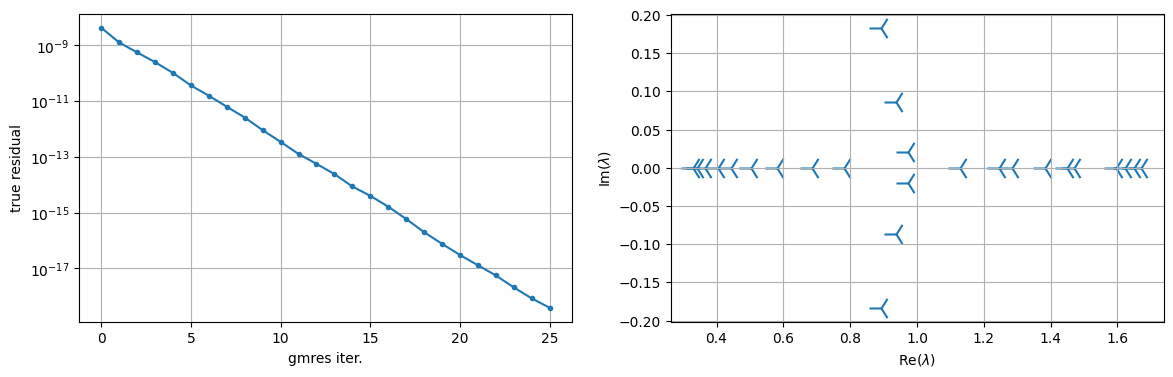

In [55]:
schema_5_4 = SolveSchema(
    groups=[5],
    solve='use_invertor',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(abs(bmat.mat)) / 6,
    # invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    invertor=lambda bmat: inv_block_diag(lump_nd(bmat.mat, nd=model.nd), nd=model.nd),


    # complement=SolveSchema(
    #     groups=[4],
    #     # solve=lambda bmat: inv_block_diag_2x2(bmat.mat),
    #     solve=lambda bmat: inv_block_diag(bmat.mat, nd=model.nd),
    # )
)

mat_permuted, prec = make_solver(schema=schema_5_4, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.0


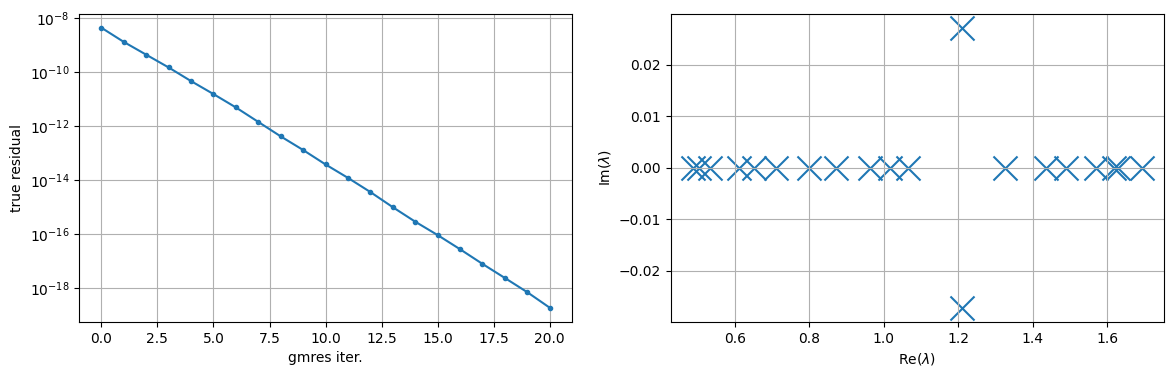

In [57]:
J55 = J[[5]]

def build_lumped_J55(J55: BlockMatrixStorage):
    bmats = []  
    for i in range(len(J55.active_subgroups[0])):
        row = []
        for j in range(len(J55.active_subgroups[1])):
            row.append(lump_nd(J55.slice_domain(i, j), nd=model.nd))
        bmats.append(row)

    return bmat(bmats)


J45_lumped = J[[4,5]]
J45_lumped[5, 5] = build_lumped_J55(J[[5]])

# solve_petsc(J55.mat, inv(tmp), rhs=J55.local_rhs(rhs)); plt.show()
solve_petsc(J[[4, 5]].mat, build_mechanics_stabilization(model=model, bmat=J45_lumped, build_schur=False), rhs=J[[4, 5]].local_rhs(rhs)); plt.show()


# spy(inv(tmp))
